# Tuning your own models 

Here we demonstrate how AutoGluon's HPO methods can help you tune various pieces of your own non-AutoGluon/non-MXNet models. As an example, we consider a custom PyTorch model for classifying images from the [MNIST handwritten digit dataset](https://en.wikipedia.org/wiki/MNIST_database). The PyTorch code used in this tutorial is adapted from this [git repo](https://github.com/kuangliu/pytorch-cifar). In your applications, this code can be replaced with analogous code for your own model.

In order to run the second half of this tutorial, please first [install PyTorch](https://pytorch.org/).



## Search Space Overview

We first explain some of the search spaces supported by AutoGluon, including simple search spaces (`Int`, `Real`, and `Categorical`) and nested search spaces (`Categorical`, `List`, `Dict`). Each search space describes the set of possible values for a hyperparameter, from which the searcher will try training models with particular values during hyperparameter optimization. AutoGluon also enables search spaces inside user-defined Python objects using the decorator `@ag.obj` and user-defined functions using the decorator `@ag.func`.

Let's start by importing AutoGluon:

In [1]:
import autogluon as ag

**Integer Space**: The searcher will choose an integer between the provided lower and upper bounds.

In [2]:
a = ag.space.Int(lower=0, upper=10)
print(a)

Int: lower=0, upper=10


Sample a random value from the search space:

In [3]:
a.rand

0

**Real Space**: The searcher will choose an integer between the provided lower and upper bounds.

In [4]:
b = ag.space.Real(lower=1e-4, upper=1e-2)
print(b)

Real: lower=0.0001, upper=0.01


We can also specify that values should be searched on a logarithmic rather than linear scale between these bounds:

In [5]:
c = ag.space.Real(lower=1e-4, upper=1e-2, log=True)
print(c)

print("Example configuration:", c.rand)

Real: lower=0.0001, upper=0.01
Example configuration: 0.0008096174072908544


**Categorical Space**: The searcher will chooses one value from a discrete set of values. The first value listed corresponds to the *default* that will be tried first during the search.

In [6]:
d = ag.space.Categorical('Monday', 'Tuesday', 'Wednesday')
print(d)

print("Example configuration:", d.rand)

Categorical['Monday', 'Tuesday', 'Wednesday']
Example configuration: Wednesday


## Nested Search Space

A categorical space can also be used as a nested search space, where its options may themselves be search spaces.

In [7]:
a_b_or_c = ag.space.Categorical(a, b, c)
print(a_b_or_c)

which_space = a_b_or_c.rand
print("Example configuration is also a search space:\n", which_space)

which_value = which_space.rand
print("Example configuration from the previously-selected search space:\n", which_value)

Categorical[Int: lower=0, upper=10, Real: lower=0.0001, upper=0.01, Real: lower=0.0001, upper=0.01]
Example configuration is also a search space:
 Int: lower=0, upper=10
Example configuration from the previously-selected search space:
 8


**List Space**: The Searcher will choose one option from each element of the list (where each element is a search space), and then return a list of these choices. This can be useful for specifying things like network architectures which might require choosing the width of each layer say.

In the example below, the first element of the list is an `Int` space sampled
from 0 to 3, and the second element is a `Categorical` space sampled
from the choices `'alpha'` or `'beta'`.

In [8]:
f = ag.space.List(
        ag.space.Int(0, 3),
        ag.space.Categorical('alpha', 'beta'),
    )
print(f)

print("Example configuration:", f.rand)

List[Int: lower=0, upper=3, Categorical['alpha', 'beta']]
Example configuration: [2, 'alpha']


**Dict Space**: Similar to a `List` space, a configuration returned by the Searcher will be a dict where the values of each key will be chosen from among the options provided in this `Dict` space. 

In the example below, the value of `'key1'` is chosen from
a `Categorical` space with the choices `'alpha'` or `'beta'`,
and the value of `'key2'` is chosen from an `Int` space that spans 0-9.

In [9]:
g = ag.space.Dict(
        key1=ag.space.Categorical('alpha', 'beta'),
        key2=ag.space.Int(0, 9),
        key3='constant'
    )
print(g)

print("Example configuration:", g.rand)

Dict{'key1': Categorical['alpha', 'beta'], 'key2': Int: lower=0, upper=9, 'key3': 'constant'}
Example configuration: {'key1': 'alpha', 'key2': 3, 'key3': 'constant'}


## Decorators for Searchable Objects and Training Functions

We now demonstrate how you can insert search spaces into arbitrary Python objects and functions, without really needing to modify their existing code.

**Searchable Object:** With the addition of one AutoGluon decorator, any object returned by a user-defined class can have its constructor-arguments turned into searchable hyperparameters.

In [10]:
@ag.obj(
    name=ag.space.Categorical('auto', 'gluon'),
    static_value=10,
    rank=ag.space.Int(2, 5),
)
class MyObj:
    def __init__(self, name, rank, static_value):
        self.name = name
        self.rank = rank
        self.static_value = static_value
    def __repr__(self):
        repr = 'MyObj -- name: {}, rank: {}, static_value: {}'.format(
                self.name, self.rank, self.static_value)
        return repr

h = MyObj()
print(h)
print("Example configuration:", h.rand)

AutoGluonObject -- MyObj
Example configuration: MyObj -- name: auto, rank: 3, static_value: 10


Note that none of the of the existing `MyObj` code would need to be modified in order to make this object searchable. We just added the `@ag.obj` decorator and provided a search space to consider. 

**Custom Training Function:** `train_func` is where to put your model training script, which takes in various keyword `args` as its hyperparameters. Usually, your training-script will evaluate your model (either at the end of training or after each epoch) and log this somewhere. The only extra code required to hyperparameter-tune your training-function with AutoGluon is to add the evaluation-score into the provided `reporter` object as well. Here, we show a dummy `train_func` that doesn't do much.

In [11]:
@ag.args(
    a=ag.space.Int(1, 10),
    b=ag.space.Real(1e-3, 1e-2),
    c=ag.space.Real(1e-3, 1e-2, log=True),
    d=ag.space.Categorical('a', 'b', 'c', 'd'),
    e=ag.space.Bool(),
    f=ag.space.List(
            ag.space.Int(1, 2),
            ag.space.Categorical(4, 5),
        ),
    g=ag.space.Dict(
            a=ag.Real(0, 10),
            obj=MyObj(),
        ),
    h=ag.space.Categorical('test', MyObj()),
)
def train_fn(args, reporter=None):
    performance = args.a + args.b + args.c # you should do stuff here
    epoch = 0 # can (optionally) record each epoch's performance 
    print('args: {}'.format(args))
    print('performance: ', performance)
    if reporter is not None:
        reporter(epoch=epoch, performance=performance)

## Begin Hyperparameter-tuning your Custom Code

With all the pieces in place, we're ready to create a Searcher object, which will follow a particular hyperparameter-tuning strategy (basic random search in this case).

In [12]:
searcher = ag.searcher.RandomSearcher(train_fn.cs)
config = searcher.get_config()
print(config)

{'a': 6, 'b': 0.0055, 'c': 0.0031622777, 'd▁choice': 0, 'e': 0, 'f▁0': 2, 'f▁1▁choice': 0, 'g▁a': 5.0, 'g▁obj▁name▁choice': 0, 'g▁obj▁rank': 4, 'h▁1▁name▁choice': 0, 'h▁1▁rank': 4, 'h▁choice': 0}


Note that `config` contains indices corresponding to choices of `Categorical` hyperparameters and AutoGluon's internal representations of certain nested hyperparameters. 
Here's how to run one training job with this hyperparameter-configuration specified by the searcher:

In [13]:
train_fn(train_fn.args, config)

args: {'a': 6, 'b': 0.0055, 'c': 0.0031622777, 'd': 'a', 'e': 0, 'f': [2, 4], 'g': {'a': 5.0, 'obj': MyObj -- name: auto, rank: 4, static_value: 10}, 'h': 'test', '_default_config': {}}
performance:  6.0086622777


Finally, we can tune the argument-values of this `train_fn` by creating a scheduler that serially orchestrates training jobs under hyperparameter-configurations specified by this searcher.

In [14]:
scheduler = ag.scheduler.FIFOScheduler(train_fn, searcher=searcher,
                                       resource={'num_cpus': 2, 'num_gpus': 0},
                                       num_trials=7,
                                       reward_attr='performance', # name of performance metric in reporter 
                                       time_attr='epoch') # name of time-attribute in reporter
scheduler.run()
scheduler.join_jobs()
best_config = scheduler.get_best_config()
best_perf = scheduler.get_best_reward() # assumes higher values = better
print("\nBest configuration:\n", best_config)
print("\nBest performance value:\n", best_perf)

scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 7


args: {'a': 4, 'b': 0.00834265613313634, 'c': 0.005740342482431713, 'd': 'b', 'e': 1, 'f': [2, 4], 'g': {'a': 5.6177650049668495, 'obj': MyObj -- name: auto, rank: 5, static_value: 10}, 'h': 'test', 'task_id': 0}
performance:  4.014082998615568
args: {'a': 7, 'b': 0.0025860934950148106, 'c': 0.007035691031609521, 'd': 'b', 'e': 1, 'f': [2, 5], 'g': {'a': 4.1863394009431145, 'obj': MyObj -- name: gluon, rank: 3, static_value: 10}, 'h': 'test', 'task_id': 1}
performance:  7.009621784526624
args: {'a': 3, 'b': 0.003760566924092516, 'c': 0.007004655038721295, 'd': 'd', 'e': 0, 'f': [1, 4], 'g': {'a': 8.419395583612442, 'obj': MyObj -- name: auto, rank: 2, static_value: 10}, 'h': 'test', 'task_id': 2}
performance:  3.0107652219628136
args: {'a': 2, 'b': 0.009383737772154229, 'c': 0.004485339037776226, 'd': 'b', 'e': 1, 'f': [1, 5], 'g': {'a': 1.7120445565470621, 'obj': MyObj -- name: auto, rank: 5, static_value: 10}, 'h': 'test', 'task_id': 3}
performance:  2.0138690768099305
args: {'a': 9,

# Tuning PyTorch Model for MNIST

We'll now demonstrate these concepts for a practical application of training a Pytorch neural network on the MNIST image dataset. Let's first import the necessary packages:

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

Here are some random images from each class in the MNIST dataset:

<img src="files/images/MnistExamples.png" width="400" height="400">

We'll apply standard image transforms to our training and validation images:

In [16]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

# load the datasets:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Main Training Script

The following `train_mnist` function represents normal training code you'd write for
fitting neural networks to the MNIST data. In Python, one can use an argparser to conveniently
change default argument values. If your training function does this, then the only additional argument you need to add to your existing code is a `reporter` object that logs performance achieved after each training epoch.

In [17]:
def train_mnist(args, reporter):
    # get variables from args
    lr = args.lr
    wd = args.wd
    epochs = args.epochs
    net = args.net
    print('lr: {}, wd: {}'.format(lr, wd))

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Model
    net = net.to(device)

    if device == 'cuda':
        net = nn.DataParallel(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=wd)

    # datasets and dataloaders
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    # Training
    def train(epoch):
        net.train()
        train_loss, correct, total = 0, 0, 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    def test(epoch):
        net.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100.*correct/total
        # This is the only extra line to add to your code:
        reporter(epoch=epoch+1, accuracy=acc) # 'epoch' reports the number of epochs completed

    for epoch in tqdm(range(0, epochs)):
        train(epoch)
        test(epoch)

## Using AutoGluon for HPO

Now we demonstrate how to define a searchable network architecture, convert the training function to be searchable, create the scheduler, and then launch the HPO experiment.

### Define a Searchable Network Achitecture

Let's define a 'dynamic' network with searchable configurations by simply adding our `@ag.obj` decorator. In this example, we search two arguments `hidden_conv` and
`hidden_fc`, which represent the number of channels/hidden-units in convolutional/fully-connected layers. 

In [18]:
@ag.obj(
    hidden_conv=ag.space.Int(6, 12),
    hidden_fc=ag.space.Categorical(80, 120, 160),
)
class Net(nn.Module): # put your Pytorch network here
    def __init__(self, hidden_conv, hidden_fc):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_conv, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hidden_conv, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, hidden_fc)
        self.fc2 = nn.Linear(hidden_fc, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Make the Training Function Searchable

We can simply add the `@ag.args` decorator and the `train_mnist` function argument values will become tunable by AutoGluon. In the example below, we specify that `lr` is a real-value that should be searched on a log-scale in the range 0.01 - 0.2. Before passing `lr` to your train function, AutoGluon always selects an actual floating point value to assign to `lr`, so your existing code doesn't need to change for accommodating the hyperparameter search.

In [19]:
@ag.args(
    lr = ag.space.Real(0.01, 0.2, log=True),
    wd = ag.space.Real(1e-4, 5e-4, log=True),
    net = Net(),
    epochs=5, # small value used here for quick demo, you should increase this to see more realistic performance.
)
def ag_train_mnist(args, reporter):
    return train_mnist(args, reporter)

### Create the Scheduler and Launch the Experiment

For hyperparameter tuning, AutoGluon provides different schedulers you can choose from:

- [**FIFOScheduler**](https://autogluon.mxnet.io/api/autogluon.scheduler.html#autogluon.scheduler.FIFOScheduler): Each training jobs runs for the full number of epochs

- [**HyperbandScheduler**](https://autogluon.mxnet.io/api/autogluon.scheduler.html#hyperbandscheduler): Uses Hyperband with successive halving in order to terminate unpromising jobs in early epochs, to free compute resources for new training jobs.

Each scheduler is internally configured by a searcher, which determines what hyperparameter configurations should be tried. The default searcher simply draws configurations uniformly at random from the search space.

In [20]:
myscheduler = ag.scheduler.FIFOScheduler(ag_train_mnist,
                                         resource={'num_cpus': 4, 'num_gpus': 1},
                                         num_trials=2, # small value used here for quick demo, you should increase this to see more realistic performance.
                                         time_attr='epoch',
                                         reward_attr="accuracy")
print(myscheduler)

scheduler_options: Key 'searcher': Imputing default value random
scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True



FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.68.247/10038/1' processes=1 threads=4, memory=64.28 GB>, Resource: NodeResourceManager(4 CPUs, 1 GPUs))
})



In [21]:
myscheduler.run()
myscheduler.join_jobs()

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


lr: 0.0447213595, wd: 0.0002236068




lr: 0.028245913732173278, wd: 0.00017160776862349322


We plot the test accuracy achieved over the course of training under each hyperparameter configuration that AutoGluon tried out (represented as different colors).

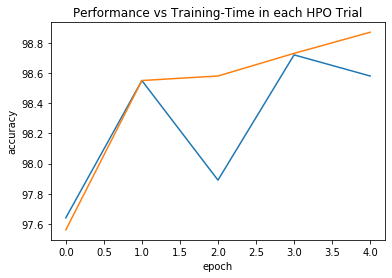

The best configuration is: 
{'lr': 0.028245913732173278, 'net▁hidden_conv': 11, 'net▁hidden_fc▁choice': 0, 'wd': 0.00017160776862349322}
Validation accuracy achieved under this configuration = 98.87


In [22]:
myscheduler.get_training_curves(plot=True,use_legend=False)
best_config = myscheduler.get_best_config()
best_acc = myscheduler.get_best_reward()
print('The best configuration is: \n{}'.format(best_config))
print('Validation accuracy achieved under this configuration =', best_acc)

## Hyperparameter search via Asynchronous BOHB 

When training neural networks, it is often more efficient to early-terminate unpromising trials, and Hyperband scheduling can save a lot of wall-clock time. However, Hyperband relies entirely on randomly sampled configurations. As it completes more training jobs under different hyperparameter configurations, a good AutoML system should rather learn which sorts of configurations tend to work well and hone in on these promising regions of the search space (as done in Bayesian optimization). [BOHB](https://arxiv.org/abs/1807.01774) is a recent hyperparameter-search strategy that combines the early-termination strengths of Hyberband with the better-than-random configuration proposals of Bayesian optimization. 

AutoGluon provides an improved [asynchronous BOHB implementation](https://arxiv.org/abs/2003.10865) that can also be used to tune your custom model like this:

In [23]:
bohb_scheduler = ag.scheduler.HyperbandScheduler(
    ag_train_mnist,
    resource={'num_cpus': 4, 'num_gpus': 1},
    searcher='bayesopt',
    num_trials=4, # small value used here for quick demo, you should increase this to see more realistic performance.
    time_attr='epoch',
    reward_attr='accuracy')
print(bohb_scheduler)

max_t = 5, as inferred from train_fn.args
scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'grace_period': Imputing default value 1
scheduler_options: Key 'reduction_factor': Imputing default value 3
scheduler_options: Key 'brackets': Imputing default value 1
scheduler_options: Key 'type': Imputing default value stopping
scheduler_options: Key 'keep_size_ratios': Imputing default value False
scheduler_options: Key 'maxt_pending': Imputing default value False
scheduler_options: Key 'searcher_data': Imputing default value rungs
scheduler_options: Key 'do_snapshots': Imputing default value False

scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

search_options: Key 'random_seed': Imputing default value 31415927
search_options: Key 'opt_skip_init_length': Imputing default value 150

HyperbandScheduler(terminator: HyperbandStopping_Manager(reward_attr: accuracy, time_attr: epoch, reduction_factor: 3, max_t: 5, brackets: [Bracket: Iter 3.000: None | Iter 1.000: None])


Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 4


lr: 0.0447213595, wd: 0.0002236068


lr: 0.028245913732173278, wd: 0.00017160776862349322


lr: 0.18869688885602873, wd: 0.00023865057332689288



lr: 0.14193763233841836, wd: 0.00037124134442677336


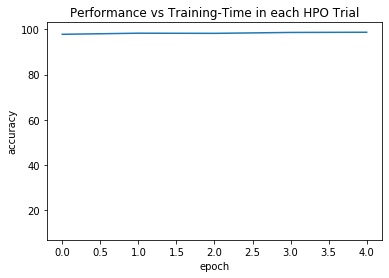

The best configuration is: 
{'lr': 0.028245913732173278, 'net▁hidden_conv': 11, 'net▁hidden_fc▁choice': 0, 'wd': 0.00017160776862349322}
Validation accuracy achieved under this configuration = 98.87


In [24]:
bohb_scheduler.run()
bohb_scheduler.join_jobs()

bohb_scheduler.get_training_curves(plot=True,use_legend=False)
best_config_bohb = bohb_scheduler.get_best_config()
best_acc_bohb = bohb_scheduler.get_best_reward()
print('The best configuration is: \n{}'.format(best_config))
print('Validation accuracy achieved under this configuration =', best_acc)

### References

[**AutoGluon Documentation** (autogluon.mxnet.io)](https://autogluon.mxnet.io/api/autogluon.task.html)

Bose A. [**Handwritten Digit Recognition Using PyTorch**](https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627). *Towards Data Science*, 2019.

Falkner et al. [**BOHB: Robust and efficient hyperparameter optimization at scale**](http://proceedings.mlr.press/v80/falkner18a). In: *ICML*, 2018.

Klein et al. [**Model-based Asynchronous Hyperparameter and Neural Architecture Search**](https://arxiv.org/abs/2003.10865). *Arxiv*, 2020.